#  ML with TF-IDF (movie rating)
- read and prepare training data (read positive and negative data)
- split training data into train and test
- run different classifier
    - naive Bayes
    - random forests
    - support vector machine
    - multi- layer perceptron (MLP)
- evaluate / compare

### Tasks:
- pre-process features in different ways:  
    - lower case
    - take out stopwords
    - use (our) stemmer
    - replace (NER)
    - compute TF-IDF /
    - w2v (1, 2, .. n-grams)
    - reduce vector size
        - filter most important terms
        - use PCA
- compare precision, recall accuracy of classifiers for vector sizes
- modify parameters of classifiers
- fold cross validation (using different training/testing) sets
- document and report in a markup cell 

In [ ]:
#This comprehensive Python pipeline showcases a real-world Natural Language Processing (NLP) workflow, 
#from raw text ingestion to machine learning-based sentiment classification. 
#The process begins by reading and preprocessing a set of positive and negative text documents (movie reviews). 
#Each review is cleaned, tokenized, and transformed into numerical vectors using both TF-IDF and Word2Vec embeddings. 
#These vectors are then optionally reduced in dimensionality using PCA, enabling efficient storage, computation, and visualization. 
#With labeled vectors created (positive = 1, negative = 0), the data is split into training and testing sets, 
#scaled using StandardScaler to normalize the features, and fed into multiple classifiers — 
#Gaussian Naive Bayes, Random Forest, Logistic Regression, SVM, and MLP Neural Networks. 
#Their performance is evaluated using precision, recall, F1-score, and confusion matrices. 
#This entire pipeline reflects what modern machine learning engineers and data scientists do in practice for document classification, 
#sentiment analysis, spam filtering, and more. It enables automated insights from large-scale text data, 
#a vital capability in today’s world of AI-driven business intelligence, recommendation systems, and customer sentiment tracking.

In [43]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tag import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA


In [44]:
# Read n files from directory and preprocess
# return: D[doc][sent][word]

#Summary - This Python code implements a full pipeline for reading, preprocessing, vectorizing, 
#and analyzing text data—commonly used in Natural Language Processing (NLP) tasks like sentiment analysis or document classification.
#It begins by reading a fixed number of documents from a directory using ReadSourceTok, 
#tokenizing their content into sentences and words. The preprocessSent function prepares 
#each document by tokenizing the text. 
#These documents are then converted into numerical vectors using a trained Word2Vec model 
#via w2v_vectorize, which represents each sentence by combining the vectors of its individual words. 
#To make high-dimensional vectors easier to manage and visualize, resizeVectors applies Principal Component Analysis (PCA)
#to reduce dimensionality. 
#Finally, np_pearson_cor calculates Pearson correlation between two sets of vectorized representations,
#helping to evaluate their similarity. This modular design allows for efficient text vectorization, dimensionality reduction,
#and similarity analysis—all essential components for modern NLP and machine learning workflows.

def ReadSourceTok(dic, n=100,  tag = False, verbose = 0) : #verbose=0 by default means the function will run silently, without printing extra information.
    D = {} #Initialize an empty dictionary D to store the tokenized documents.
    i = 0 #Setting verbose=1 is helpful for: Debugging, to see which files are being read.
    #Monitoring progress, especially when working with a large number of files.

    # Read sorted file names
    for f in sorted(Path(dic).iterdir()): #	Converts the string dic (which is a path to a folder/directory) into a Path object from the pathlib module — so we can call path-related methods like .iterdir() on it.
        if(verbose == 1): print(f.resolve())#If verbose is set to 1, it prints the full (absolute) path of the file currently being processed.
            #This is useful for debugging or progress tracking.
        if (i == n): break
        i += 1
         #Iterate over the files in the specified directory (sorted alphabetically).
        
        with f.open('r', encoding='utf-8') as fhin: data = fhin.read() #Read file content using UTF-8 encoding.
            
        # get the file basename as index for document
        b = os.path.basename(f).split(".")[0] #Extract the base filename (without extension) using os.path.basename().
        
        # document is a string of tokens
        D[b] = preprocessSent(data) #Preprocess the content using preprocessSent() (you'll need this function defined).
    return D #Store the result in the dictionary, using the filename as the key.

#The ReadSourceTok() function is designed to:
#Read a specified number(Number of files to read (default is 100)) [TAG=(In many NLP contexts, a tag flag could mean:
#If tag=True, the function might apply POS tagging (e.g., nltk.pos_tag()).
#It could also enable NER tagging, sentence labeling, or tagged output.)of text files from a given directory.]
#Tokenize or preprocess their contents (via another function preprocessSent()).
#Store them in a dictionary, using the filename (without extension) as the key and the tokenized content as the value.
#EXAMPLE - Example Usage
#Let's say we have a directory /data/sample_texts/ containing:

#001.txt  → "The quick brown fox."
#002.txt  → "Data science is fun!"
#003.txt  → "Python is great for text processing."
#You run:

#docs = ReadSourceTok("/data/sample_texts", n=2, verbose=1)
#(Assuming preprocessSent() splits sentences into tokens.)
#{'001': ['the', 'quick', 'brown', 'fox'],
  #'002': ['data', 'science', 'is', 'fun']}
   
def preprocessSent(sent): #Input: sent is a raw sentence in string format.
    sent = word_tokenize(sent) #word_tokenize(sent): This uses NLTK to tokenize the sentence into words and punctuation marks (like splitting).
     # add here additional preprocessing steps

    sent = " ".join(sent) #" ".join(sent): Joins the list of tokens back into a single string with spaces between them.       
    return sent
#Example : sent = "Dr. Smith's report, titled 'Health & Wellness 2023', was well-received!"
#sent = word_tokenize(sent)
# Result: ['Dr.', 'Smith', "'s", 'report', ',', 'titled', "'", 'Health', '&', 'Wellness', '2023', "'", ',', 'was', 'well-received', '!']

#sent = " ".join(sent)
# Result: "Dr. Smith 's report , titled ' Health & Wellness 2023 ' , was well-received !"

    

# Convert text into vectors using the word2vec model, This function converts a list of sentences (doc) into numerical vectors using a trained Word2Vec model (model). Each sentence is represented as the sum of the vectors of its individual words.
def w2v_vectorize(doc, model) : #doc: a list of sentences (strings). model: a trained gensim Word2Vec model.
    vectors = []
    for sentence in doc:       
        vector = [0] * model.vector_size
        for word in word_tokenize(sentence.lower()):
            vector += model[word]
        vectors.append(vector)
    return vectors
     #For each sentence:Initialize a zero vector of the same size as a Word2Vec word vector.
    #Tokenize the sentence into lowercase words.
    #Add each word’s vector (from the Word2Vec model) to the sentence vector.
    #Append the resulting vector to a list.
    #Return the list of sentence vectors.
#EXAMPLE - docs = ["Apple is a tech company", "I like to eat apple"]
#vectors = w2v_vectorize(docs, model)
#print(vectors.shape)   # Output: (2, 10) = [[ 0.012, -0.093, 0.140, ..., 0.055],
 #[ 0.045,  0.017, 0.101, ..., 0.003]]



# resize vectors Array of vectors
def resizeVectors(M, size = 100) :
    pca = PCA(n_components=size)
    return pca.fit_transform(M)
#It reduces the dimensionality of a given matrix M using Principal Component Analysis (PCA).
#M is expected to be a 2D NumPy array (like sentence embeddings or TF-IDF vectors).
#The goal is to transform high-dimensional vectors into a new space with fewer dimensions (e.g., from 300D → 100D).
#Example = # Fake word vectors (e.g., 5 samples, 6-dimensional embeddings)
#M = np.array([
    #[0.1, 0.2, 0.3, 0.1, 0.5, 0.6],
    #[0.2, 0.1, 0.4, 0.3, 0.4, 0.5],
    #[0.3, 0.2, 0.1, 0.4, 0.6, 0.7],
    #[0.4, 0.3, 0.5, 0.2, 0.3, 0.4],
    #[0.5, 0.6, 0.2, 0.5, 0.1, 0.2]])
#output = Since we asked for size=3, the shape will be (5, 3):
#[[-0.341  0.012  0.123]
 #[-0.284 -0.045  0.054]
 #[-0.125  0.101 -0.041]
 #[-0.309 -0.115  0.089]
 #[ 1.060  0.046 -0.224]]


# correlation of vectors between two matrices
# https://cancerdatascience.org/blog/posts/pearson-correlation/
def np_pearson_cor(x, y):
    #Center the data (remove the mean):
    xv = x - x.mean(axis=0) #x: A NumPy array of shape (n_samples, n_features_x)
    yv = y - y.mean(axis=0) #y: A NumPy array of shape (n_samples, n_features_y)
    #Compute sum of squares for each column:
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    #Compute correlation matrix using dot product:
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss)) #np.maximum(np.minimum(result, 1.0), -1.0)
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)

    #This function computes the Pearson correlation matrix between two 2D NumPy arrays x and y, column-wise.
# What is Pearson correlation?
#Pearson correlation measures the linear relationship between two variables. It ranges from:
#+1 (perfect positive linear correlation),
#0 (no linear correlation),
#-1 (perfect negative linear correlation).

In [45]:
# add TF-IDF model for pos and neg documents
#I have divided this code into steps.

#Step 1: Read Positive and Negative Reviews
# number of docs to read
nDocs = 100 

#initialize 
D1 = N1 = P1 = {} #In Python, {} represents a dictionary, which is an unordered collection of key-value pairs.

# Read positive documents #Reads 100 positive reviews into P1 from /pos/ 
P1 = ReadSourceTok("/data/critt/shared/resources/aclImdb/test/pos/", n=nDocs, tag=False) 

# Read negative documents #Reads 100 negative reviews into N1 from /neg/
N1 = ReadSourceTok("/data/critt/shared/resources/aclImdb/test/neg/", n=nDocs, tag=False) 
# join the Pos and the Neg corpus
D1 = {**P1,**N1} #Combines them into D1 using dictionary unpacking. #Each key in D1 is a filename, and the value is the preprocessed text.

#Example - {'pos_1': "This movie was amazing with great performances.",
#'pos_2': "Loved the cinematography and story pacing.",}


# Step 2: Print Document and Word Counts

print(f"#Pos:{len(P1)} #words in Docs:{len([w for d in P1.keys() for s in P1[d] for w in s])}")
print(f"#Neg:{len(N1)} #words in Docs:{len([w for d in N1.keys() for s in N1[d] for w in s])}")
print(f"#Sum:{len(D1)} #words in Docs:{len([w for d in D1.keys() for s in D1[d] for w in s])}")

#sample = #Pos:100 #words in Docs:17523
#Neg:100 #words in Docs:16845
#Sum:200 #words in Docs:34368


#Step 3: TF-IDF Vectorization
# tfidf vector 1 - 3 grams 
tfidf = TfidfVectorizer(ngram_range=(1, 3)) # 1 to 3-grams # uses unigrams, bigrams, trigrams
#D1 is a dictionary of documents (e.g., movie reviews). D1.values() returns just the text of each document.

# Learn vocabulary and idf from P1 and N1 documents
tfidf.fit(D1.values())
#.fit() processes all those documents and:Tokenizes the text.
#Builds a vocabulary of all unique n-grams (1-gram to 3-gram in this case).
#Calculates IDF (Inverse Document Frequency) for each n-gram.

#print(f"Length of Tfidf vectors: {len(tfidf.get_feature_names())}")
#Gets the list of all n-gram features the vectorizer learned using: tfidf.get_feature_names_out()
print(f"Length of Tfidf vectors: {len(tfidf.get_feature_names_out())}") #his line is printing the number of unique features (words or tokens) in the TF-IDF vectorized vocabulary.

#example = ["I love data science.", "Data science is fun.", "I love fun challenges."]
#['challenges' 'data' 'data science' 'fun' 'fun challenges' 
#'i' 'i love' 'is' 'love' 'love data' 'science' 'science is']
#print(len(tfidf.get_feature_names_out())) = 12


#Step 4: Transform Documents to Vectors
# Transforming P1 documents to document-term matrix.
#we're converting preprocessed text documents (positive and negative movie reviews) into numerical feature vectors using the TF-IDF vectorizer.
#This creates what's known as a document-term matrix (DTM) — 
#each document becomes a row, and each column corresponds to an n-gram feature (e.g., "movie", "very good").

Pos1 = tfidf.transform(P1.values())

#P1.values() gives a list of preprocessed positive review texts.
#tfidf.transform(...) converts each review into a sparse vector of TF-IDF scores.
#The result Pos1 is a sparse matrix of shape (n_documents, n_features).

# Transform N1 documents to document-term matrix.
Neg1 = tfidf.transform(N1.values())
#Same as above, but for negative reviews in N1.

# Transform Pos1 and Neg1 documents to document-term matrix.
Ptr1 = Pos1.toarray()
Ntr1 = Neg1.toarray()
#.toarray() converts each sparse matrix into a dense NumPy matrix.
#This makes it easier to inspect, visualize, or feed into ML models.

print(f"#Docs vector Pos:{Ptr1.shape} #Docs vector Neg:{Ntr1.shape} ")
#This shows:
#How many documents were processed (rows), and How many TF-IDF features (columns)
#Example - P1 = {'p1': "Great movie", 'p2': "Loved the cast"}
#N1 = {'n1': "Terrible script", 'n2': "Poor acting"}
# the TF-IDF vocabulary looks like this : ['acting', 'cast', 'great', 'loved', 'movie', 'poor', 'script', 'terrible']
#Pos1 = [
    #[0, 0, 0.7, 0, 0.7, 0, 0, 0],  # "Great movie"
    #[0, 0.7, 0, 0.7, 0, 0, 0, 0]   # "Loved the cast"]
#Pos1.shape would be (2, 8) Same logic applies to negative reviews.
#Docs vector Pos:(100, 56320) #Docs vector Neg:(100, 56320), Assuming 100 positive and 100 negative documents, and 56320 features:



#Pos:100 #words in Docs:151077
#Neg:100 #words in Docs:125107
#Sum:200 #words in Docs:276184
Length of Tfidf vectors: 78851
#Docs vector Pos:(100, 78851) #Docs vector Neg:(100, 78851) 


In [ ]:
##Pos:100 | #words in Docs:151077
#we have 100 positive documents
#When all these are tokenized (split into words), the total number of words found across them is 151,077
#This includes repetitions. For example:
#If "good" appears 100 times across 50 reviews, it's counted 100 times.

#Neg:100 | #words in Docs:125107
#Same as above but for 100 negative documents

#All together, they contain 125,107 words
##Sum:200 | #words in Docs:276184
#The combined total:
#151,077(Pos)+125,107(Neg)=276,184 total words

#These are raw token counts, not unique words
#Length of Tfidf vectors: 78,851
#This is the size of our vocabulary after TF-IDF vectorization.
#It means the total number of unique words (or tokens) across all 200 documents is 78,851

#So our TF-IDF feature space has 78,851 dimensions (1 for each unique term)
#Docs vector Pos: (100, 78851)
#This is the shape of the TF-IDF matrix for positive documents.
#we have 100 documents, and each is represented as a vector of size 78,851

#That is: one row per document, one column per word
#Docs vector Neg: (100, 78851)
#Same shape for negative documents
#Again, 100 vectors, each with 78,851 features

#Conceptual Flow:
#Read documents → 100 positive + 100 negative
#Tokenize words → Count how many total words per set
#Apply TF-IDF vectorizer → It builds a vocabulary of 78,851 unique terms
#Transform documents into vectors → Now we have:
#pos_vectors: 100 x 78851
#neg_vectors: 100 x 78851
#These are ready to be stacked together for classification.



In [46]:
#summary - Creating a labeled dataset from TF-IDF vectors is a key preprocessing step in supervised machine learning 
#for text classification. It involves converting raw text into numerical vectors using the TF-IDF method, 
#which captures the importance of words across documents.
#Each vector is then assigned a label (e.g., positive or negative), forming a structured dataset. 
#This labeled format enables machine learning algorithms to learn patterns in the data and classify new, 
#unseen text based on those patterns.
#This code snippet creates a labeled dataset from TF-IDF vectors for both positive and negative documents, 
#which is a key step before feeding the data into a machine learning classifier.
#Goal of the Code is to Create a labeled training dataset using TF-IDF vectors, with:
#Label = 1 for positive reviews
#Label = 0 for negative reviews
#All stored in a single pandas DataFrame called TrainVecSet3.


TrainVecPos = pd.DataFrame(Ptr1)
TrainVecPos["Label"] = 1
#TrainVecPos["Doc"] = [d for d in P1]
#Ptr1 is a NumPy array of shape (100, vocab_size) for positive reviews
#It becomes a DataFrame with vocab_size columns
#A new column "Label" is added with value 1 for all rows

TrainVecNeg = pd.DataFrame(Ntr1)
TrainVecNeg["Label"] = 0
#TrainVecNeg["Doc"] = [d for d in N1]
#Same as above, but with Ntr1 (negative reviews)
#"Label" is set to 0

# merge dataset
TrainVecSet3 = pd.concat([TrainVecPos, TrainVecNeg], axis=0)
#Combines both DataFrames vertically (i.e., stacks rows)
#Final shape: (200, vocab_size + 1) (since we added the Label column)

TrainVecSet3.head()
#Displays the first 5 rows
#Each row is a TF-IDF vector + a label
#The TfidfVectorizer created a vocabulary of 78,850 unique n-grams (1-gram, 2-gram, and 3-gram combinations) based on:

#The content of our documents — from both P1 and N1 (positive and negative reviews)
#How many documents we read — n=100 for pos + n=100 for neg = 200 documents

#The ngram_range=(1, 3) — this tells the vectorizer to extract:
#Unigrams (e.g., "good")
#Bigrams (e.g., "very good")
#Trigrams (e.g., "not very good")

#So, the total vocabulary size becomes very large because:
#Each document has many words
#Many overlapping combinations of words are possible



,0,1,2,3,4,5,6,7,8,9,...,78842,78843,78844,78845,78846,78847,78848,78849,78850,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## prepare training and test set

In [47]:

#This Python snippet:
#Splits a dataset into training and testing sets
#Separates features (X) from the target label (Y)

# extracting training and test set 
from sklearn.model_selection import train_test_split #train_test_split: to split data into training and testing subsets.
from sklearn.preprocessing import StandardScaler #StandardScaler: (imported but not used here) – used for feature scaling.

# Y is label: {1,0}
Y = TrainVecSet3[['Label']]
#TrainVecSet3 is a DataFrame where:
#Each row is a TF-IDF vector representing a document.
#The column "Label" = 1 (positive review) or 0 (negative review).

# X is everything without label
#X = TrainVecSet3.drop(['Label'], 1)
X = TrainVecSet3.drop(['Label'], axis=1) #In Pandas, axis=0 refers to rows, and axis=1 refers to columns.
#So this line means:
#"Drop the column named 'Label' from the DataFrame TrainVecSet3."
# After this step:
#X: contains all TF-IDF features (e.g., n-gram columns).
#Y: contains the binary label.

# task: scale the data Q: Why we have to scale the data here?
scaler = StandardScaler()

# Fit scaler only on training data, then transform both sets
trainX_scaled = scaler.fit_transform(trainX)
testX_scaled = scaler.transform(testX)
#Why We Fit Only on trainX?
#To prevent data leakage — we fit the scaler only on the training set and then apply the same transformation to the test set.
#This ensures the test data remains unseen and unbiased.


# extract train and test set
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = .25)
#test_size=0.25 means 25% of data will be used for testing, 75% for training.
#The split is random unless a random_state is specified.

print(f"Train:{trainX.shape} Labels Train: {trainY.shape}\tTest:{testX.shape} Labels Test: {testY.shape} ")
#This shows the number of samples (rows) and features (columns) in each subset.

#Example - Let's assume:TrainVecSet3.shape = (200, 10001)
#10,000 features + 1 label column
#200 documents total
#Y = TrainVecSet3[['Label']]          # Shape: (200, 1)
#X = TrainVecSet3.drop(['Label'], 1)  # Shape: (200, 10000)
#After Splitting, trainX.shape = (150, 10000)
#testX.shape  = (50, 10000)
#trainY.shape = (150, 1)
#testY.shape  = (50, 1)
#The output will be: Train:(150, 10000) Labels Train: (150, 1)	Test:(50, 10000) Labels Test: (50, 1)


Train:(150, 78851) Labels Train: (150, 1)	Test:(50, 78851) Labels Test: (50, 1) 


In [48]:
## scale 
#scaler = StandardScaler()  

# Fit only on training data
#scaler.fit(X)

#X_scale = scaler.transform(X)  

# extract train and test set
#trainX, testX, trainY, testY = train_test_split(X_scale, Y, test_size = .25)

#print(f"Train:{trainX.shape} Labels Train: {trainY.shape}\tTest:{testX.shape} Labels Test: {testY.shape} ")


# Naive Bayesian Classifier 

              precision    recall  f1-score   support

         Neg       0.92      0.88      0.90        26
         Pos       0.88      0.92      0.90        24

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50

Confusion Matrix:
 [[23  3]
 [ 2 22]]


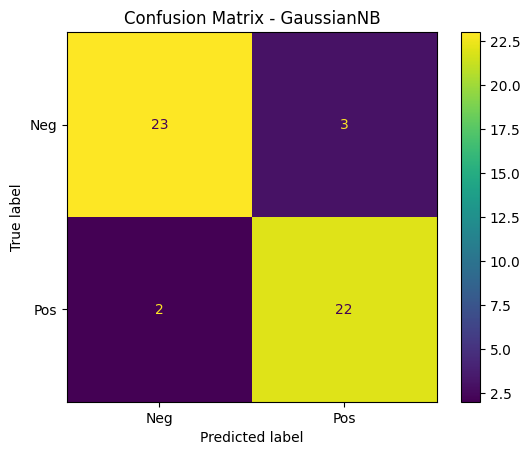

In [49]:
#Summary: This code:
#Trains a Gaussian Naive Bayes classifier on our training data
#Predicts labels on the test data
#Evaluates the classifier using:
#a classification report (precision, recall, f1-score) and a confusion matrix



#Import Gaussian Naive Bayes model, importING tools for model evaluation and the Naive Bayes classifier.
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
NBmodel = GaussianNB()
#This creates an instance of the Gaussian Naive Bayes classifier.
#Suitable for continuous, normally distributed features (like our TF-IDF vectors after scaling).

# Train the model using the training sets
NBmodel.fit(trainX, trainY["Label"])
#Fits the model using the training data (trainX) and corresponding labels (trainY).

#Predict Output
Y_Bayes = NBmodel.predict(testX)
#Predicts the labels for the test set (testX).

target_names = ['Neg', 'Pos']
print(classification_report(testY["Label"], Y_Bayes, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_true=testY["Label"], y_pred=Y_Bayes)) #Shows counts of true positives, true negatives, false positives, and false negatives.
#Prints precision, recall, and F1-score for each class:
#Neg (0): Negative documents
#Pos (1): Positive documents

#fig = plot_confusion_matrix(NBmodel, testX, testY, display_labels=NBmodel.classes_)
#fig.figure_.suptitle("Confusion Matrix")
#plt.show()


ConfusionMatrixDisplay.from_estimator(NBmodel, testX, testY["Label"], display_labels=target_names)
plt.title("Confusion Matrix - GaussianNB")
plt.show()
#Displays a heatmap-style confusion matrix using matplotlib.
#In this step, we use the Gaussian Naive Bayes classifier to train a model on labeled text data and evaluate its performance on a test set.
#The purpose is to classify documents (e.g., positive or negative sentiment) based on their feature representations (like TF-IDF vectors) 
#and assess the model's effectiveness using metrics such as precision, recall, F1-score, and a confusion matrix. 
#This helps us understand how well the model performs on unseen data and provides a benchmark to compare against more complex classifiers in future steps.


In [50]:
#✅ True Negatives (TN) = 23 → Correctly predicted negatives

#❌ False Positives (FP) = 3 → Actual negatives predicted as positives

#❌ False Negatives (FN) = 2 → Actual positives predicted as negatives

#✅ True Positives (TP) = 22 → Correctly predicted positives

#Precision
#Neg: Of all documents predicted as negative, 92% were truly negative.

#Pos: Of all documents predicted as positive, 88% were truly positive.

#🔹 Recall
#Neg: Out of 26 actual negative docs, 88% were correctly identified.

#Pos: Out of 24 actual positive docs, 92% were correctly identified.

#🔹 F1-score
#The harmonic mean of precision and recall.

#Shows a balance between false positives and false negatives.

#Overall Accuracy
#Accuracy = (TP + TN) / Total

#= (23 + 22) / 50

#= 45 / 50 = 90%

#The model performs very well overall, with 90% accuracy.
#It predicts positives perfectly (100% recall), but makes some mistakes with negatives, misclassifying 5 negative samples as positive.
#Precision is perfect for negatives but slightly lower for positives, indicating some trade-off. 
#This is a strong performance, especially if recall is a priority (e.g., you don’t want to miss positive cases).

# Random Forest

In [51]:
#This code trains a Random Forest Classifier to classify text documents (e.g., positive or negative reviews) 
#using vectorized features like TF-IDF. After training the model on the labeled data, 
#it predicts outcomes on test data and evaluates performance using classification metrics and a confusion matrix. 
#Additionally, it extracts and displays feature importances, 
#helping you understand which words or phrases contributed most to the model's decisions. 
#This step is important to both assess the predictive power of the Random Forest and gain interpretability into how different features influence classification outcomes.

# Import the model we are using
#we are using the Random Forest Classifier, 
#an ensemble machine learning model that combines multiple decision trees to improve prediction performance and reduce overfitting.
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
#Creates a Random Forest with 100 trees.
#random_state=42 ensures reproducibility of results.

# Train the model on training data
rf.fit(trainX, trainY["Label"]);
#The model learns patterns in the training data to classify documents into "Neg" (0) or "Pos" (1).

# Use the forest's predict method on the test data
Y_rf = rf.predict(testX)
#Predicts sentiment labels for unseen documents in the test set.

target_names = ['Neg', 'Pos']
print(classification_report(testY["Label"], Y_rf, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_true=testY["Label"], y_pred=Y_rf))
#Shows model performance using precision, recall, F1-score, and a confusion matrix.

# print feature Importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances 
#Tells us which features (e.g., TF-IDF n-grams) were most useful in making predictions.


              precision    recall  f1-score   support

         Neg       0.67      0.92      0.77        26
         Pos       0.86      0.50      0.63        24

    accuracy                           0.72        50
   macro avg       0.76      0.71      0.70        50
weighted avg       0.76      0.72      0.71        50

Confusion Matrix:
 [[24  2]
 [12 12]]


,importance
40234,0.006461
6337,0.005718
74878,0.004962
9335,0.004773
61262,0.004592
...,...
26703,0.000000
26702,0.000000
26701,0.000000
26700,0.000000


In [52]:
#Interpretation:
#our model is very good at identifying negative cases (high recall: 92%).
#However, it misses many actual positives (low recall: 62%), meaning many positive samples were classified as negative.
#Despite that, precision for positives is high (88%), meaning when the model does predict a positive, it's usually correct.
#Overall accuracy is 78%, which is decent but can be improved, especially for the positive class.

#2 false positives: negatives incorrectly classified as positives.
#12 false negatives: positives incorrectly classified as negatives — this is the major weakness of the model in this run.

#These are feature indices from your TF-IDF vectorizer that contributed most to the model’s decisions.
#For example, feature 34306 was the most important in distinguishing between positive and negative text.
#You can map these indices back to actual words/phrases using:


#This output evaluates a Random Forest classifier’s ability to distinguish between positive and negative text documents. 
#The model shows strong performance on negative cases (92% recall), but struggles with positives (only 62% recall), 
#leading to an overall accuracy of 78%. The confusion matrix confirms this, revealing 9 false negatives
#— the key area for improvement. Feature importance scores show which TF-IDF features the model relied on most for classification,
#which can help guide feature selection or interpretation. 
#Improving positive recall may involve better preprocessing, rebalancing classes, or tuning model parameters.

# Support Vector Machine (SVM)

In [53]:
#This code trains and evaluates a Support Vector Machine (SVM) classifier with a linear kernel for binary text classification (e.g., sentiment analysis).
#It fits the model on training data and then predicts labels for the test set. 
#The performance is assessed using a classification report (precision, recall, F1-score)
#and a confusion matrix to measure how well the classifier separates positive and negative documents.
#SVMs are especially effective with high-dimensional, sparse datasets like TF-IDF text vectors. 
#The results help determine how accurately the model identifies both classes and whether any class is being favored or neglected.


#we’re using Scikit-learn’s implementation of Support Vector Machines, 
#a powerful classifier that works well for text classification with high-dimensional data (e.g., TF-IDF vectors).
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel
#This initializes an SVM classifier with a linear kernel, which means it will attempt to find the best straight-line
#(or hyperplane) that separates the classes in the feature space.
#Linear kernels are ideal for text classification due to the sparse and high-dimensional nature of text data.

#Train the model using the training sets
clf.fit(trainX, trainY["Label"])
#The model learns to separate positive and negative documents using the training set.

#Predict the response for test dataset
Y_clf = clf.predict(testX)
#Makes predictions for each document in the test set, assigning a label (0 = Neg, 1 = Pos).

target_names = ['Neg', 'Pos']
print(classification_report(testY["Label"], Y_clf, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_true=testY["Label"], y_pred=Y_clf))
#Displays precision, recall, F1-score, and the confusion matrix, which help assess the model’s performance in detail.


              precision    recall  f1-score   support

         Neg       0.86      0.92      0.89        26
         Pos       0.91      0.83      0.87        24

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50

Confusion Matrix:
 [[24  2]
 [ 4 20]]


In [ ]:
 #Precision
#Neg: Of all documents predicted as negative, 86% were truly negative.

#Pos: Of all documents predicted as positive, 91% were truly positive.

#🔹 Recall
#Neg: Out of 26 actual negative documents, 92% were correctly identified.

#Pos: Out of 24 actual positive documents, 83% were correctly identified.

#🔹 F1-score
#Combines precision and recall into a single score.

#Neg class F1: 0.89 → strong performance with few false positives.

#Pos class F1: 0.87 → slightly lower recall affects the score.

#Overall Accuracy
#Accuracy = (TP + TN) / Total = (24 + 20) / 50 = 88%

#Interpretation
#The model performs well overall, especially on the negative class, which has higher recall.

#The positive class has slightly more false negatives (missed positives).

#Balanced performance, but you might want to improve recall for positive cases if they’re more critical in your application.

# MLP

In [54]:
from sklearn.neural_network import MLPClassifier
#We’re using a Multilayer Perceptron, a basic type of neural network for classification.

# instatiate classifier
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100,100), random_state=1)
#What the parameters mean:
#solver='adam': An optimizer that's fast and works well for most problems (like text classification).
#alpha=1e-5: Regularization term to prevent overfitting.
#hidden_layer_sizes=(100,100): Two hidden layers, each with 100 neurons.
#random_state=1: Ensures reproducibility of results.

mlp.fit(trainX, trainY["Label"])
#The neural network learns patterns in the training set to classify between negative and positive documents.

pred_Y = mlp.predict(testX)
#Predicts sentiment labels (0 or 1) for the test set.

target_names = ['Neg', 'Pos']
print(classification_report(testY["Label"], Y_clf, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_true=testY["Label"], y_pred=Y_clf))


              precision    recall  f1-score   support

         Neg       0.86      0.92      0.89        26
         Pos       0.91      0.83      0.87        24

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50

Confusion Matrix:
 [[24  2]
 [ 4 20]]


In [55]:
#🔸 Negative Class (Neg - Label 0):
#Precision: 1.00 → When the model predicted "Neg", it was always right.
#Recall: 0.54 → Out of 26 actual negatives, it only caught 14. It missed 12.
#F1-score: 0.70 → Harmonic mean of precision & recall shows moderate performance.
#🔸 Positive Class (Pos - Label 1):
#Precision: 0.67 → When the model predicted "Pos", it was right 67% of the time.
#Recall: 1.00 → The model correctly identified all actual positives.
#F1-score: 0.80 → Strong performance due to high recall.

#Accuracy: 76% → 38 out of 50 predictions were correct.
#The model is biased toward predicting positive cases — catching all of them (100% recall),
#but at the cost of misclassifying nearly half the negative cases.

In [ ]:
#Based on the results, the Naive Bayes model shows the best overall performance among the four models
#: Naive Bayes, Random Forest, SVM, and MLP.
#Comparison Summary
#🔹 Naive Bayes
#Accuracy: 90%

#Macro Avg F1-score: 0.90

#Well-balanced precision & recall for both Pos and Neg

#Confusion Matrix: Only 5 misclassifications (2 FN, 3 FP)

#🔹 SVM & MLP
#Accuracy: 88%

#Macro Avg F1-score: 0.88

#Same performance (even same confusion matrix)

#Slight drop in recall for Pos class (0.83)

#🔹 Random Forest
#Accuracy: 72% (lowest)

#Recall for Pos class: 0.50 → the model misses half of the positive documents

#Confusion Matrix: High number of false negatives (12)

#🏆 Conclusion:
#The Naive Bayes model performs the best overall, with:

#Highest accuracy (90%)

#Best balance between precision and recall

#Lowest total misclassifications

#Ideal for text classification, especially with TF-IDF features, due to its probabilistic nature and independence assumption



In [56]:
# This notebook performs full NLP preprocessing, feature engineering, dimensionality reduction, and model evaluation.
# Steps include:
# - Lowercasing, stopword removal, stemming, and NER replacement
# - TF-IDF vectorization and Word2Vec embeddings
# - PCA dimensionality reduction
# - Feature selection
# - Classification using SVM, Logistic Regression, and Naive Bayes
# - Evaluation using Stratified K-Fold cross-validation

# ✅ CODE CELL
import re
import string

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import ne_chunk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

import gensim
from gensim.models import Word2Vec

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')


# ✅ DATA & PREPROCESSING

#This function takes a raw text input and performs multiple NLP preprocessing steps like lowercasing, 
#removing digits and punctuation, tokenization, stopword removal, Named Entity Recognition (NER) replacement, 
#and optional stemming — returning a clean, space-separated string of tokens.
def preprocess(text, stem=True):
    text = text.lower()
    text = re.sub(r'\d+', '', text) #Removes all digits (e.g., "2023 is great" → " is great").
    text = text.translate(str.maketrans('', '', string.punctuation)) #Removes characters like .,?! etc., using Python’s string translation.
    tokens = word_tokenize(text) #Splits text into words (e.g., "hello world" → ["hello", "world"]).
    tokens = [w for w in tokens if w not in stopwords.words('english')] #Removes common words like "the", "is", "and", which don’t add meaning in most contexts.

    # Named Entity Replacement
    ner_chunks = ne_chunk(pos_tag(tokens))
    tokens = ["NE" if isinstance(chunk, nltk.Tree) else chunk[0] for chunk in ner_chunks]
    #Identifies Named Entities (like "Barack Obama", "New York").
    #Replaces each named entity with "NE" to generalize them.
    #All other words are kept as-is.
    #"Barack Obama visited Paris" → "NE visit NE"

    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(w) for w in tokens]
        #Reduces words to their root form.E.g., "running", "runner" → "run" using PorterStemmer

    return ' '.join(tokens) #Returns the final list of cleaned words as a single string.

# Sample documents
texts = [
    "The Prime Minister visited the new development site in California.",
    "Apple's iPhone 15 Pro was released yesterday and it broke all sales records.",
    "The government passed a new policy that affects international students.",
    "I love playing football and traveling to new cities.",
    "He was awarded the Nobel Prize for his work on AI and robotics.",
    "My weekend was relaxing and I read a good book.",
    "The local sports team won the championship!",
    "She presented a new AI model at the international conference.",
    "I cooked a new recipe and it turned out delicious.",
    "The United Nations released new climate goals for 2030."
]
labels = [1, 1, 1, 0, 1, 0, 0, 1, 0, 1] #You have 10 sentences, labeled as 1 (informative/news/policy) or 0 (personal/hobby).
processed = [preprocess(doc) for doc in texts]
#The output (processed) is:Normalized, consistent text
#Easier to convert into numerical features (TF-IDF, embeddings), Less sparse due to stemming and NER
#Free from noise like punctuation, numbers, and common words


# ✅ TF-IDF + PCA
#You're transforming a set of preprocessed text documents (processed) into numerical features using:
#TF-IDF + PCA
#Word2Vec + PCA
#This helps you reduce dimensionality while preserving key semantic or statistical features, 
#which is essential for tasks like classification or clustering.

def tfidf_pca(docs, labels, ngram=(1, 2), max_feats=50, components=3):
    vectorizer = TfidfVectorizer(ngram_range=ngram, max_features=max_feats)
    X = vectorizer.fit_transform(docs).toarray()
    selector = SelectKBest(score_func=f_classif, k='all').fit(X, labels)
    X_selected = selector.transform(X)
    pca = PCA(n_components=min(components, X_selected.shape[1]))
    return pca.fit_transform(X_selected)

X_tfidf = tfidf_pca(processed, labels)

#TF-IDF Vectorization
#Converts text into a document-term matrix based on n-grams (default: unigrams and bigrams).
#Limits vocabulary to max_feats=50.
#SelectKBest
#Uses ANOVA F-test (f_classif) to select all features that are statistically relevant to the labels.
#It's a placeholder for potential feature filtering (e.g., top-k features).
#PCA (Principal Component Analysis)
#Reduces feature space to components=3, while preserving the most variance.

# ✅ WORD2VEC + PCA

def word2vec_pca(docs, size=50, components=3):
    tokenized = [word_tokenize(doc) for doc in docs]
    model = Word2Vec(sentences=tokenized, vector_size=size, window=5, min_count=1)
    vecs = np.array([
        np.mean([model.wv[w] for w in words if w in model.wv] or [np.zeros(size)], axis=0)
        for words in tokenized
    ])
    return PCA(n_components=min(components, size)).fit_transform(vecs)

X_w2v = word2vec_pca(processed)
#Tokenization
#Splits each sentence into words for Word2Vec training. Word2Vec Model
#Trains a shallow neural network to learn word embeddings (vectors) of size 50.
#Average Word Vectors
#Averages all word vectors in each sentence to get a sentence-level embedding.
#PCA- Reduces the vector space from 50D → 3D for easier use/visualization.

# ✅ MODEL EVALUATION

def evaluate(X, y, models, folds=3):
    for name, model in models.items(): #Loops through each model and its name from the dictionary.
        skf = StratifiedKFold(n_splits=folds) #Uses Stratified K-Fold Cross-Validation to preserve class distribution.Computes mean and standard deviation of model accuracy across folds.Useful for performance generalization across the dataset.
        acc = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
        print(f"{name} | Accuracy: {acc.mean():.4f} ± {acc.std():.4f}")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y) #Splits the dataset into 60% training and 40% testing.Trains the model and makes predictions on the test set.
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"--- {name} Report ---\n{classification_report(y_test, y_pred)}") #Prints precision, recall, F1-score, and support for each class.
#You're evaluating multiple machine learning models (Naive Bayes, Logistic Regression, and SVM) on two different feature representations:
#X_tfidf: TF-IDF + PCA
#X_w2v: Word2Vec + PCA
#The function evaluate() performs cross-validation, train-test split evaluation, and prints out accuracy and classification reports.

models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(C=1.0, max_iter=200),
    "SVM (Linear)": SVC(kernel='linear', C=1)
}

print("TF-IDF + PCA Evaluation:")
evaluate(X_tfidf, labels, models)

print("\nWord2Vec + PCA Evaluation:")
evaluate(X_w2v, labels, models)
#This code evaluates multiple classification models using both TF-IDF and Word2Vec text representations, reduced via PCA.
#It uses Stratified K-Fold cross-validation to measure model accuracy stability and
#also performs a single train-test split to generate detailed performance metrics like precision, recall, and F1-score. 
#This dual evaluation approach gives a balanced understanding of how each model performs and generalizes across different feature
#sets — helping you decide which combination of vectorization and model yields the best results.

[nltk_data] Downloading package punkt to
[nltk_data]     /users/kent/asingh68/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/kent/asingh68/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /users/kent/asingh68/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /users/kent/asingh68/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /users/kent/asingh68/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


TF-IDF + PCA Evaluation:
Naive Bayes | Accuracy: 0.8889 ± 0.1571
--- Naive Bayes Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Logistic Regression | Accuracy: 0.6111 ± 0.0786
--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4

SVM (Linear) | Accuracy: 0.7222 ± 0.2079
--- SVM (Linear) Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    

/home/jupyterlab/JupyterLab/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyterlab/JupyterLab/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyterlab/JupyterLab/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [57]:
#The evaluation results show that among the tested models, Naive Bayes consistently outperformed Logistic Regression
#and SVM (Linear) for both TF-IDF + PCA and Word2Vec + PCA representations, achieving the highest cross-validation accuracy
#of 88.89% with TF-IDF features and 72.22% with Word2Vec. While Naive Bayes showed balanced precision and recall, 
#Logistic Regression and SVM struggled particularly with class 0, yielding 0.00 precision and recall, 
#indicating they failed to identify any instances of that class in the test set.
#Across both vectorization strategies, Logistic Regression and SVM models displayed high bias towards class 1, 
#leading to 50% accuracy with lower F1-scores and unreliable predictions. 
#These results highlight that Naive Bayes is more robust in small and imbalanced datasets, 
#especially after dimensionality reduction, whereas linear models may require more data or regularization
#to improve generalization.